<a href="https://colab.research.google.com/github/koyomin9zx/CS114.K21-Machine-Learning/blob/master/Case_study_2_Leaf_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preprocessing**

download dataset & extract

In [0]:
!wget  https://archive.ics.uci.edu/ml/machine-learning-databases/00338/Folio%20Leaf%20Dataset.rar
!unrar x "/content/Folio Leaf Dataset.rar"


import lib

In [0]:
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras import models, optimizers
from keras.layers import Input
from keras import layers
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.externals import joblib
import cv2

In [0]:
# Lấy các đường dẫn đến ảnh.
image_path = list(paths.list_images('Folio Leaf Dataset/Folio'))

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

In [0]:
# Đường dẫn ảnh sẽ là 'Folio Leaf Dataset/Folio/tên_loài_hoa/tên_ảnh' ví dụ 'Folio Leaf Dataset/Folio/pomme jacquot/20150324_143055.jpg' nên p.split(os.path.sep)[-2] sẽ lấy ra được tên loài hoa
labels = [p.split(os.path.sep)[-2] for p in image_path]


# One-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [0]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    
    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image)
    
    list_image.append(image)
    
list_image = np.vstack(list_image)

# **Build Model**

In [0]:
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Xây thêm các layer
# Lấy output của ConvNet trong VGG16
fcHead = baseModel.output

# Flatten trước khi dùng FCs
fcHead = Flatten(name='flatten')(fcHead)

# Thêm FC
fcHead = Dense(256, activation='relu')(fcHead)
fcHead = Dropout(0.5)(fcHead)

fcHead = Dense(128, activation='relu')(fcHead)
fcHead = Dropout(0.3)(fcHead)

# Output layer với softmax activation
fcHead = Dense(32, activation='softmax')(fcHead)

# Xây dựng model bằng việc nối ConvNet của VGG16 và fcHead
model = model = Model(inputs=baseModel.input, outputs=fcHead)

In [0]:
# Chia traing set, test set tỉ lệ 80-20
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

In [0]:
# augmentation cho training data
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
# augementation cho test
aug_test= ImageDataGenerator(rescale=1./255)

# **Training**

In [72]:
# freeze VGG model
for layer in baseModel.layers:
    layer.trainable = False
    
opt = Adam(2e-5)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
numOfEpoch = 100
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)

# unfreeze some last CNN layer:
for layer in baseModel.layers[15:]:
    layer.trainable = True

numOfEpoch = 100
opt = Adam(2e-5)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
H1 = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)


Epoch 1/100
15/15 [==============================] - 8s 554ms/step - loss: 3.8163 - accuracy: 0.0419 - val_loss: 3.4734 - val_accuracy: 0.0391
Epoch 2/100
15/15 [==============================] - 8s 515ms/step - loss: 3.4935 - accuracy: 0.0545 - val_loss: 3.3836 - val_accuracy: 0.0703
Epoch 3/100
15/15 [==============================] - 8s 508ms/step - loss: 3.4516 - accuracy: 0.0419 - val_loss: 3.3797 - val_accuracy: 0.1250
Epoch 4/100
15/15 [==============================] - 7s 495ms/step - loss: 3.3642 - accuracy: 0.0860 - val_loss: 3.3137 - val_accuracy: 0.1406
Epoch 5/100
15/15 [==============================] - 7s 482ms/step - loss: 3.3254 - accuracy: 0.0734 - val_loss: 3.2854 - val_accuracy: 0.2422
Epoch 6/100
15/15 [==============================] - 7s 479ms/step - loss: 3.3021 - accuracy: 0.0776 - val_loss: 3.2392 - val_accuracy: 0.1719
Epoch 7/100
15/15 [==============================] - 7s 486ms/step - loss: 3.2716 - accuracy: 0.1069 - val_loss: 3.1264 - val_accuracy: 0.2656

# ***Model Evaluation***


In [0]:
H.history['loss'].extend(H1.history['loss'])
H.history['accuracy'].extend(H1.history['accuracy'])
H.history['val_loss'].extend(H1.history['val_loss'])
H.history['val_accuracy'].extend(H1.history['val_accuracy'])

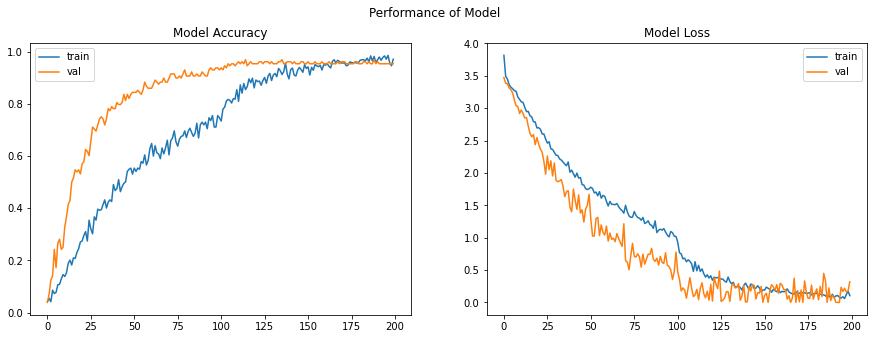

In [118]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(H.history['accuracy'])
ax1.plot(H.history['val_accuracy'])
vline_cut = np.where(H.history['val_accuracy'] == np.max(H.history['val_accuracy']))[0][0]
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'val'])

ax2.plot(H.history['loss'])
ax2.plot(H.history['val_loss'])
vline_cut = np.where(H.history['val_loss'] == np.min(H.history['val_loss']))[0][0]
ax2.set_title("Model Loss")
ax2.legend(['train', 'val'])
plt.show()